# Imports

In [65]:
import pandas as pd
import numpy as np

In [66]:
from tqdm import tqdm
import requests
import json
import math

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns 

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [68]:
# Set options
pd.set_option('precision', 2)
%matplotlib inline

---
**Account created** Jan 20, 2017

**User UID** jXtvmUtPb4aRNmVJ9ZcsO0eD8dA3

**First corrected moment** Feb 19, 2017

**Full res pics** [Link](https://console.firebase.google.com/u/0/project/minutiae-production/storage/minutiae-production.appspot.com/files~2Fproduction~2Fmoments~2FjXtvmUtPb4aRNmVJ9ZcsO0eD8dA3~2Fphotos)

**Openweathermap.org API Key** 3d4fe593c4ccd0579a1d6ce5193f64ce


---

# Data Munging

## Clean & Aggregate Data

In [63]:
# my moment location info
djw_moments = pd.read_json('data/minutiae-production-jXtvmUtPb4aRNmVJ9ZcsO0eD8dA3-export.json', orient='index').reset_index()

# moment timing list (wrong version)
moment_list = pd.read_csv('data/newTiming_Sept11.csv')

In [64]:
# timing doc from ustwo
timing = pd.read_json('/Users/djw/Downloads/moments.json', lines=True).rename_axis('moment').reset_index()

In [65]:
timing.head(2)

,moment,date,hour,minute
0,0,2016-10-26 00:00:00+00:00,16,35
1,1,2016-10-27 00:00:00+00:00,4,25


In [66]:
djw_moments.head(2)

,index,displayUrl,location,thumbnailUrl
0,moment_100,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",https://firebasestorage.googleapis.com/v0/b/mi...
1,moment_1001,https://firebasestorage.googleapis.com/v0/b/mi...,NaN,https://firebasestorage.googleapis.com/v0/b/mi...


In [67]:
# remove unneeded part of string
djw_moments['moment'] = djw_moments['index'].map(lambda x: x.lstrip('moment_'))

In [76]:
# get rid of unneccesary columns
djw_moments.drop(['thumbnailUrl', 'index'], axis=1, inplace=True)

In [78]:
# convert data type
djw_moments = djw_moments.astype({'moment': 'int16'})
# sort values
djw_moments.sort_values(by=['moment'], inplace=True)
djw_moments.head(2)

,displayUrl,location,moment
721,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",86
730,https://firebasestorage.googleapis.com/v0/b/mi...,NaN,87


In [66]:
# did I have misses either at end or beginning
djw_moments.moment.max() - djw_moments.moment.min()

1437

In [80]:
# add moment info to my locations
djw_moments = djw_moments.merge(timing, how='left', on='moment')
djw_moments.head(2)

,displayUrl,location,moment,date,hour,minute
0,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",86,2017-01-20 00:00:00+00:00,2,18
1,https://firebasestorage.googleapis.com/v0/b/mi...,NaN,87,2017-01-21 00:00:00+00:00,17,55


In [81]:
# get rid of NaNs
djw_moments = djw_moments.dropna(axis=0, subset=['date'])
djw_moments.head(2)

,displayUrl,location,moment,date,hour,minute
0,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",86,2017-01-20 00:00:00+00:00,2,18
1,https://firebasestorage.googleapis.com/v0/b/mi...,NaN,87,2017-01-21 00:00:00+00:00,17,55


## Add Lat/Long

[Mapquest](https://developer.mapquest.com/)
- [Geocoding API](https://developer.mapquest.com/documentation/geocoding-api/)

In [74]:
import requests
import json

In [88]:
djw_moments.location.value_counts()

Toronto, Canada                   397
Nice, France                       88
Paris, France                      35
Los Angeles, United States         21
Montréal, Canada                   21
Philadelphia, United States        20
Villemus, France                   15
Burlington, Canada                  8
New York, United States             7
                                    5
Boston, United States               4
Goleta, United States               4
Couches, France                     4
Santa Monica, United States         4
Champagny-en-Vanoise, France        3
Philipstown, United States          2
Mississauga, Canada                 2
Saint-Laurent-du-Var, France        1
L'Escarène, France                  1
Èze, France                         1
East Bloomfield, United States      1
Dingy-Saint-Clair, France           1
Newark, United States               1
Tobyhanna, United States            1
Bluffton, United States             1
Halifax, Canada                     1
Vence, Franc

In [89]:
# API Call
djw_moments.head(2)

,displayUrl,location,moment,date,hour,minute
0,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",86,2017-01-20 00:00:00+00:00,2,18
1,https://firebasestorage.googleapis.com/v0/b/mi...,NaN,87,2017-01-21 00:00:00+00:00,17,55


In [21]:
parameters = {
    'key' : 'Gx79RzycSAe45N2ZaCsg9SXVZj94IWHc',
    'location' : 'Toronto, Canada'
}
response = requests.get('http://www.mapquestapi.com/geocoding/v1/address', params = parameters)

data = json.loads(response.text)
data

{'info': {'statuscode': 0,
  'copyright': {'text': '© 2021 MapQuest, Inc.',
   'imageUrl': 'http://api.mqcdn.com/res/mqlogo.gif',
   'imageAltText': '© 2021 MapQuest, Inc.'},
  'messages': []},
 'options': {'maxResults': -1, 'thumbMaps': True, 'ignoreLatLngInput': False},
 'results': [{'providedLocation': {'location': 'Toronto, Canada'},
   'locations': [{'street': '',
     'adminArea6': '',
     'adminArea6Type': 'Neighborhood',
     'adminArea5': 'Toronto',
     'adminArea5Type': 'City',
     'adminArea4': '',
     'adminArea4Type': 'County',
     'adminArea3': 'ON',
     'adminArea3Type': 'State',
     'adminArea1': 'CA',
     'adminArea1Type': 'Country',
     'postalCode': '',
     'geocodeQualityCode': 'A5XAX',
     'geocodeQuality': 'CITY',
     'dragPoint': False,
     'sideOfStreet': 'N',
     'linkId': '282178726',
     'unknownInput': '',
     'type': 's',
     'latLng': {'lat': 43.651893, 'lng': -79.381713},
     'displayLatLng': {'lat': 43.651893, 'lng': -79.381713},
     '

In [90]:
# convert empty strings to Nans
djw_moments.location = djw_moments.location.replace(r'^\s*$', np.nan, regex=True)

In [91]:
for i, row in djw_moments.iterrows():
    apiAddress = djw_moments.location[i]
    parameters = {
        'key' : 'Gx79RzycSAe45N2ZaCsg9SXVZj94IWHc',
        'location' : apiAddress
    }
    response = requests.get('http://www.mapquestapi.com/geocoding/v1/address', params = parameters)

    data = json.loads(response.text)['results']
    lat = data[0]['locations'][0]['latLng']['lat']
    lng = data[0]['locations'][0]['latLng']['lng']

    djw_moments.at[i,'lat'] = lat
    djw_moments.at[i,'lng'] = lng    

In [92]:
# Save data
djw_moments.to_csv('data/minutiae_djw_clean.csv')

In [4]:
djw = pd.read_csv('data/minutiae_djw_clean.csv', index_col=0)

In [5]:
djw.tail()

,displayUrl,location,moment,date,hour,minute,lat,lng
804,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1517,2020-12-21 00:00:00+00:00,23,52,45.509062,-73.553363
805,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1520,2020-12-24 00:00:00+00:00,18,53,45.509062,-73.553363
806,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1521,2020-12-25 00:00:00+00:00,12,26,45.509062,-73.553363
807,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1522,2020-12-26 00:00:00+00:00,23,57,45.509062,-73.553363
808,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1523,2020-12-27 00:00:00+00:00,11,51,45.509062,-73.553363


## Add Weather

Data from [NASA](https://power.larc.nasa.gov/data-access-viewer/)
- [API Info](https://power.larc.nasa.gov/docs/services/api/v1/temporal/daily/)

In [75]:
# date format required = YYYYMMDD

djw['date_nasa'] = None
for i in range(len(djw.date)):
    djw['date_nasa'][i] = djw.date[i].split(' ')[0].replace('-', '')

<ipython-input-75-4761f4e2e074>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  djw['date_nasa'][i] = djw.date[i].split(' ')[0].replace('-', '')


### Test

In [57]:
# Montreal
lat = 45.509062
lon = -73.553363
date = 20200101

In [77]:
# Getting Temp @ 2m, Wind speed @10m and precipitation
url = 'https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?&request=execute&tempAverage=DAILY&identifier=SinglePoint&parameters=T2M,WS10M,PRECTOT&userCommunity=SB&lon={lon}&lat={lat}&startDate={date}&endDate={date}&outputList=JSON&user=DOCUMENTATION'

In [96]:
response = requests.get(url.format(lat=lat, lon=lon, date=date))

In [97]:
data = json.loads(response.text)
data

{'features': [{'geometry': {'coordinates': [-73.55335, 45.50907, 124.0],
    'type': 'Point'},
   'properties': {'parameter': {'PRECTOT': {'20200101': 1.1},
     'T2M': {'20200101': -3.04},
     'WS10M': {'20200101': 4.46}}},
   'type': 'Feature'}],
 'header': {'api_version': '1.1.0',
  'endDate': '20200101',
  'fillValue': '-999',
  'startDate': '20200101',
  'title': 'NASA/POWER SRB/FLASHFlux/MERRA2/GEOS 5.12.4 (FP-IT) 0.5 x 0.5 Degree Daily Averaged Data'},
 'messages': [],
 'outputs': {'json': 'https://power.larc.nasa.gov/downloads/POWER_SinglePoint_Daily_20200101_20200101_045d51N_73d55W_45b1f0d7.json'},
 'parameterInformation': {'PRECTOT': {'longname': 'Precipitation',
   'units': 'mm day-1'},
  'T2M': {'longname': 'Temperature at 2 Meters', 'units': 'C'},
  'WS10M': {'longname': 'Wind Speed at 10 Meters', 'units': 'm/s'}},
 'time': [['Main OPeNDAP Requests:', 2.47], ['Total Script:', 3.43]],
 'type': 'FeatureCollection'}

https://openweathermap.org/history`

In [70]:
from tqdm import tqdm

In [79]:
for i, row in tqdm(djw.iterrows()):
    lat = djw.lat[i]
    lon = djw.lng[i]
    date = djw.date_nasa[i]
    response = requests.get(url.format(lat=lat, lon=lon, date=date))
    
    data = json.loads(response.text)
    precipitation = data['features'][0]['properties']['parameter']['PRECTOT'][str(date)]
    wind = data['features'][0]['properties']['parameter']['WS10M'][str(date)]
    temp = data['features'][0]['properties']['parameter']['T2M'][str(date)]

    djw.at[i,'temp_2m'] = temp
    djw.at[i,'wind_10m'] = wind 
    djw.at[i, 'precipitation'] = precipitation

809it [24:21,  1.81s/it]


In [80]:
# Save data
djw.to_csv('data/minutiae_djw_clean_weather.csv')

In [ ]:
# Hist/Density of temperatures/windspeed/preciptation

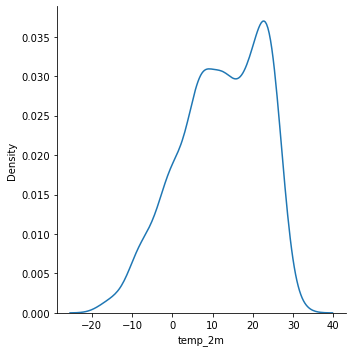

In [224]:
sns.displot(djw, x="temp_2m", kind="kde")

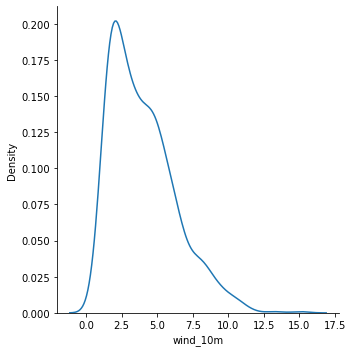

In [225]:
sns.displot(djw, x="wind_10m", kind="kde")

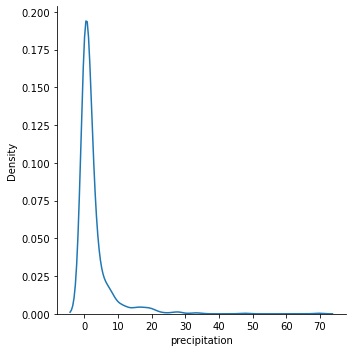

In [226]:
sns.displot(djw, x="precipitation", kind="kde")

## Add Distance

Distance between two points uses the [Haversine formula](https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python)

- calculates the **great circle** distance between two points
- current point compared to previous point

In [18]:
# realize that Nan's get assigned weird lat/lng
# this is their location: https://www.google.com/maps/place/18%C2%B047'04.7%22N+100%C2%B046'38.3%22E/@18.7846343,100.7771557,92m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d18.784635!4d100.777315

# hack: assigne lat and lng to previous row if location is NaN
for i, frame in djw.iterrows():
    if i>0:
        if pd.isnull(djw.location[i]):
            djw.loc[i, 'lat'] = djw.loc[i-1, 'lat']
            djw.log[i, 'lng'] = djw.loc[i-1, 'lng']

In [19]:
import math

In [20]:
djw['distance'] = 0

In [21]:
# create new column
djw['distance'] = 0

R = 6371 # radius of the earth in km

for i, frame in djw.iterrows():
    #can't compare first point with previous point
    if i>0:
        lat1 = math.radians(djw.lat[i-1])
        lon1 = math.radians(djw.lng[i-1])
        lat2 = math.radians(djw.lat[i])
        lon2 = math.radians(djw.lng[i])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        # Haversine formula
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2

        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = R * c
        
        djw.loc[i, 'distance'] = distance


In [22]:
djw['distance_cum'] = djw['distance'].cumsum()

## Add Previous Location
To be used to create links between locations like the airport dataframe

In [24]:
djw.loc[0,'location']

'Toronto, Canada'

In [71]:
djw['location_previous'] = None
djw['lat_previous'] = None
djw['lng_previous'] = None

for i, frame in djw.iterrows():
    if i>0:
        if pd.isnull(djw.location[i]):
            djw.loc[i, 'location'] = djw.loc[i-1,'location']
        djw.loc[i, 'location_previous'] = djw.loc[i-1, 'location']
        djw.loc[i, 'lat_previous'] = djw.loc[i-1, 'lat']
        djw.loc[i, 'lng_previous'] = djw.loc[i-1, 'lng']

## Add Greenhouse Gasses

Interesting difference between [carbon](https://ourworldindata.org/grapher/co-emissions-per-capita) and [greenhouse gasses](https://ourworldindata.org/greenhouse-gas-emissions#per-capita-greenhouse-gas-emissions-how-much-does-the-average-person-emit)!

Also nice representation of [household emissions](https://www.pbs.org/newshour/science/5-charts-show-how-your-household-drives-up-global-greenhouse-gas-emissions)...

![](images/ghg_household.png)

In [57]:
# in kg
24586/2.2 - 1653/2.2

10424.090909090908

In [72]:
# from: https://ourworldindata.org/travel-carbon-footprint
ghg = pd.read_csv('data/carbon-footprint-travel-mode.csv')

# a list of the types of transportation I used
transit_list = ['Domestic flight', 'Long-haul flight (economy)', 'Petrol car, 2 passengers', 'National rail', 'London Underground']

# subset based on those categories
ghg = ghg[ghg['Entity'].isin(transit_list)]
ghg

,Entity,GHG emissions (gCO2e/km)
5,Domestic flight,0.25
15,London Underground,0.03
17,Long-haul flight (economy),0.15
28,National rail,0.04
29,"Petrol car, 2 passengers",0.10


In [73]:
# correct incorrect labeling (these have been converted to kg, not g!)
ghg.rename(columns={"GHG emissions (gCO2e/km)": "GHG emissions (kgCO2e/km)"}, inplace=True)

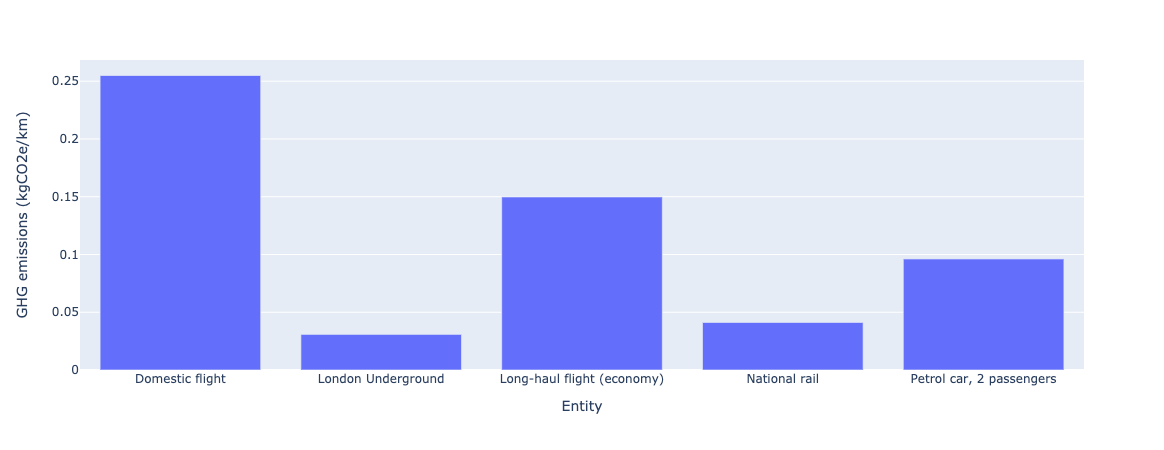

In [74]:
# visualize
import plotly.express as px

fig = px.bar(ghg, x='Entity', y='GHG emissions (kgCO2e/km)')
fig.show()

In [75]:
# take mean of these categories and multiply by the `distance_cum column`
# convert to kg
mean_ghg_kg = ghg['GHG emissions (kgCO2e/km)'].mean()

djw['carbon_footprint'] = djw['distance_cum'] * mean_ghg_kg

In [76]:
djw.tail(3)

,displayUrl,location,moment,date,hour,minute,lat,lng,date_nasa,temp_2m,wind_10m,precipitation,distance,distance_cum,location_previous,carbon_footprint,lat_previous,lng_previous
806,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1521,2020-12-25 00:00:00+00:00,12,26,45.51,-73.55,20201225,4.86,5.05,16.56,0,97613,"Montréal, Canada",11183.91,46,-74
807,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1522,2020-12-26 00:00:00+00:00,23,57,45.51,-73.55,20201226,-4.55,6.49,1.34,0,97613,"Montréal, Canada",11183.91,46,-74
808,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1523,2020-12-27 00:00:00+00:00,11,51,45.51,-73.55,20201227,-8.27,3.14,0.09,0,97613,"Montréal, Canada",11183.91,46,-74


In [77]:
# Save data
djw.to_csv('data/minutiae_djw_clean_all.csv')

# Load Data

In [44]:
djw = pd.read_csv('data/minutiae_djw_clean_all.csv', index_col=0)
djw.head(5)

,displayUrl,location,moment,date,hour,minute,lat,lng,date_nasa,temp_2m,wind_10m,precipitation,distance,distance_cum,location_previous,carbon_footprint,lat_previous,lng_previous
0,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",86,2017-01-20 00:00:00+00:00,2,18,43.65,-79.38,20170120,1.82,3.85,0.59,0,0,NaN,0.0,NaN,NaN
1,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",87,2017-01-21 00:00:00+00:00,17,55,43.65,-79.38,20170121,20.32,1.79,0.00,0,0,"Toronto, Canada",0.0,43.65,-79.38
2,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",89,2017-01-23 00:00:00+00:00,2,36,43.65,-79.38,20170123,1.96,8.04,0.53,0,0,"Toronto, Canada",0.0,43.65,-79.38
3,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",90,2017-01-24 00:00:00+00:00,10,0,43.65,-79.38,20170124,-0.35,4.38,0.91,0,0,"Toronto, Canada",0.0,43.65,-79.38
4,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",91,2017-01-25 00:00:00+00:00,14,30,43.65,-79.38,20170125,1.19,4.48,1.61,0,0,"Toronto, Canada",0.0,43.65,-79.38


In [60]:
djw.loc[djw.moment==1459].displayUrl

782    https://firebasestorage.googleapis.com/v0/b/mi...
Name: displayUrl, dtype: object

# Mapping

## locations w/ Frequency `Plotly`

In [92]:
# create location count dataframe
location_count = djw.location.value_counts().reset_index()
location_count.rename(columns={"index": "location", "location": "count"}, inplace=True)
locations = location_count.merge(djw, how='left', on='location')

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns 

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

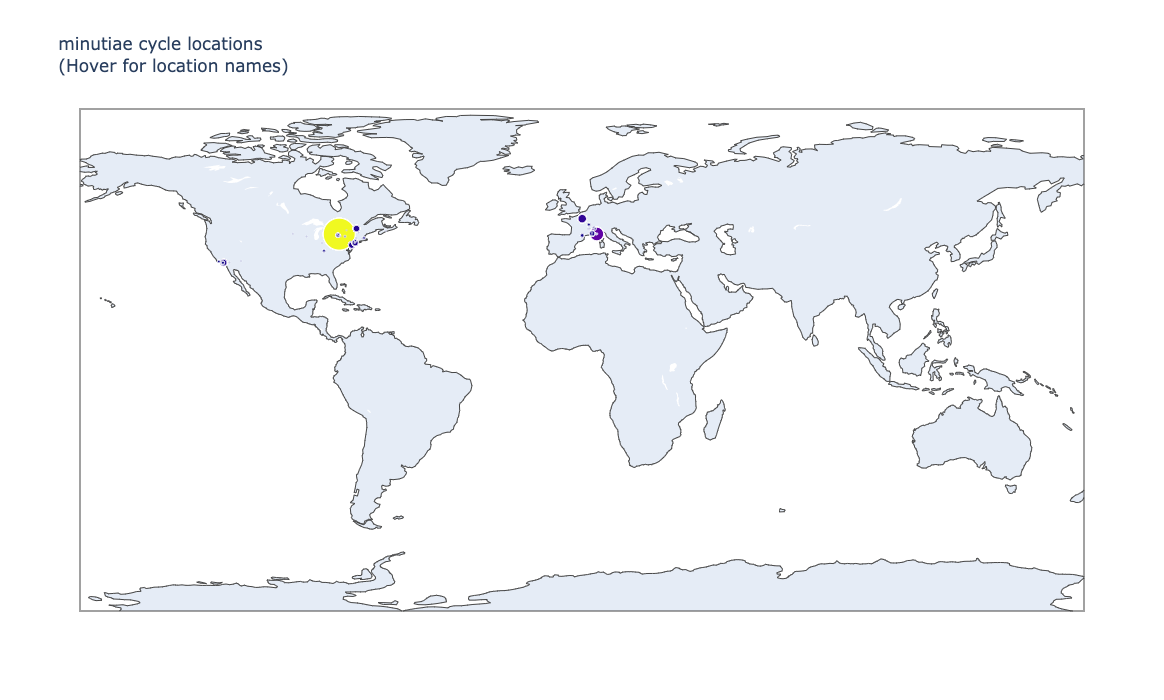

In [69]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        lon = locations['lng'],
        lat = locations['lat'],
        text = locations['location'],
        mode = 'markers',
        marker = dict(
            size = locations['count'],
            #color = colors[i],
            #line_color='rgb(40,40,40)',
            #line_width=0.5,
            sizemode = 'area'
        ),
        marker_color = locations['count'],
        ))

# fig.update_geos(projection_type="orthographic")

fig.update_layout(
        title = 'minutiae cycle locations<br>(Hover for location names)',
        geo_scope='world',
        height=700,
    )
fig.show()

## Locations w/ Frequency `GeoPandas`

In [25]:
#https://hub.arcgis.com/datasets/a21fdb46d23e4ef896f31475217cbb08_1
world_map = gpd.read_file('data/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')

In [26]:
# convert coordinate reference system
world_map = world_map.to_crs("EPSG:4326")

In [32]:
djw.lat.min()

34.010932000000004

In [30]:
world_map.total_bounds

array([-180.        ,  -90.        ,  180.        ,   83.62359619])

In [33]:
world_map.total_bounds = [djw.lng.min() -5, djw.lat.min() -5, djw.lng.max() +5, djw.lat.max() +5]

/Users/djw/opt/miniconda3/envs/thesis_env/lib/python3.8/site-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


AttributeError: can't set attribute

In [27]:
geometry = [Point(xy) for xy in zip(djw.lng, djw.lat)]

In [73]:
# specify coordinate reference system
crs = {'init': "EPSG:4326"}

In [75]:
geo_df = gpd.GeoDataFrame(djw,
                         crs = crs,
                         geometry = geometry)

/Users/djw/opt/miniconda3/envs/thesis_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


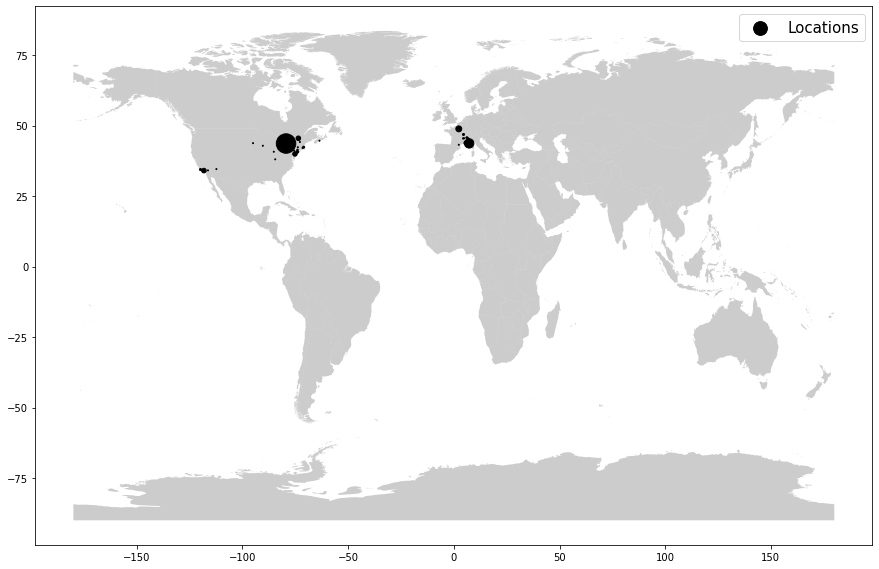

In [81]:
fig,ax = plt.subplots(figsize = (15,15))
world_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df.plot(ax = ax, markersize = djw['count'], color = 'black', marker = 'o', label = "Locations")
plt.legend(prop={'size': 15})

## Lines between locations

From [plotly tutorial](https://plotly.com/python/lines-on-maps/)

In [7]:
import plotly.graph_objects as go
import pandas as pd

In [11]:
# create location count dataframe
location_count = djw.location.value_counts().reset_index()
location_count.rename(columns={"index": "location", "location": "count"}, inplace=True)
locations = location_count.merge(djw, how='left', on='location')

In [8]:
djw.head(2)

,displayUrl,location,moment,date,hour,minute,lat,lng,date_nasa,temp_2m,wind_10m,precipitation,distance,distance_cum,location_previous,carbon_footprint,lat_previous,lng_previous
0,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",86,2017-01-20 00:00:00+00:00,2,18,43.65,-79.38,20170120,1.82,3.85,0.59,0,0,NaN,0.0,NaN,NaN
1,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",87,2017-01-21 00:00:00+00:00,17,55,43.65,-79.38,20170121,20.32,1.79,0.00,0,0,"Toronto, Canada",0.0,43.65,-79.38


In [12]:
# lets get rid of rows without travel
travel = djw.loc[djw.location!=djw.location_previous,:]

# remove first row (NaN value)
travel = travel.loc[1:,:].reset_index(drop=True)
travel.head(3)

,displayUrl,location,moment,date,hour,minute,lat,lng,date_nasa,temp_2m,wind_10m,precipitation,distance,distance_cum,location_previous,carbon_footprint,lat_previous,lng_previous
0,https://firebasestorage.googleapis.com/v0/b/mi...,"Los Angeles, United States",120,2017-02-23 00:00:00+00:00,14,45,34.05,-118.24,20170223,5.00,4.90,0.07,3494,3494,"Toronto, Canada",400.32,43.65,-79.38
1,https://firebasestorage.googleapis.com/v0/b/mi...,"Toronto, Canada",125,2017-02-28 00:00:00+00:00,21,56,43.65,-79.38,20170228,4.59,4.67,1.55,3494,6988,"Los Angeles, United States",800.64,34.05,-118.24
2,https://firebasestorage.googleapis.com/v0/b/mi...,"Mississauga, Canada",132,2017-03-07 00:00:00+00:00,4,54,43.59,-79.65,20170307,6.96,7.69,7.38,22,7010,"Toronto, Canada",803.16,43.65,-79.38


In [13]:
# make dataframe where only one row for each location
location_single = locations.drop_duplicates(subset=['location'])

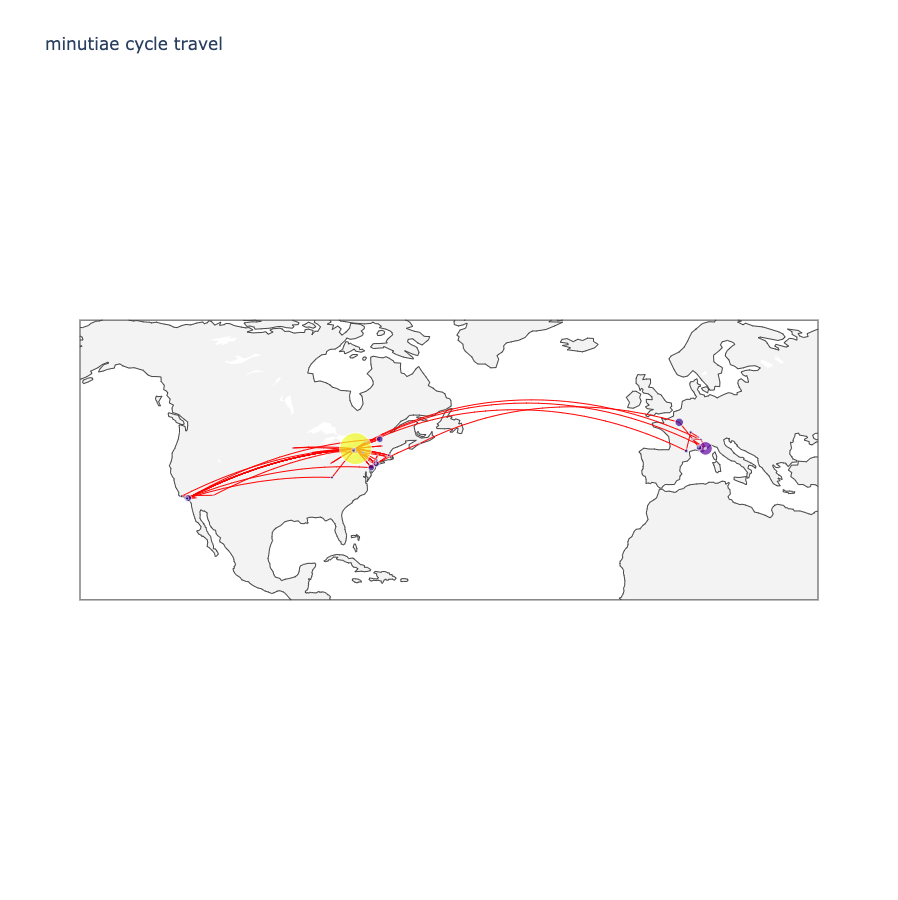

In [95]:
fig = go.Figure()
#fig.write_html('first_figure.html', auto_open=True)



flight_paths = []
for i in range(len(travel)):
    fig.add_trace(
        go.Scattergeo(
            #locationmode = 'USA-states',
            text = travel['location_previous'][i].split(',')[0] + ' to ' + travel['location'][i].split(',')[0],
            hoverinfo = 'text',
            lon = [travel['lng_previous'][i], travel['lng'][i]],
            lat = [travel['lat_previous'][i], travel['lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            #opacity = float(travel['cnt'][i]) / float(travel['cnt'].max()),
        )
    )

fig.add_trace(go.Scattergeo(
    #locationmode = 'USA-states',
    lon = location_single['lng'],
    lat = location_single['lat'],
    hoverinfo = 'text',
    text = location_single['location'],
    mode = 'markers',
    marker = dict(
            size = location_single['count'],
            #color = colors[i],
            #line_color='rgb(40,40,40)',
            #line_width=0.5,
            sizemode = 'area'
        ),
        marker_color = location_single['count']
#     marker = dict(
#         size = 2,
#         color = 'rgb(255, 0, 0)',
#         line = dict(
#             width = 3,
#             color = 'rgba(68, 68, 68, 0)'
#             )
#         )
    ))

fig.update_layout(
    title_text = 'minutiae cycle travel',
    showlegend = False,
    geo = dict(
        scope = 'world',
        projection_type = "natural earth",
        #projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
        lataxis_range=[travel.lat.min()-20,travel.lat.max()+20], lonaxis_range=[travel.lng.min()-20, travel.lng.max()+20],
    ),
    height=900,
)

fig.show()

---
# Download all pics

---

[This](https://betterprogramming.pub/building-an-imagedownloader-with-multiprocessing-in-python-44aee36e0424) is a few functions that use multithreading to download a batch of images. 
- Script saved as `image_downloader.py`
- Takes an image-list `.txt` file as input

**Usage**
```bash
python3 image_downloader.py cats.txt
```

---

There is a column (`displayUrl`) with all of the filenames in the original dataframe

In [37]:
# note these are the display quality images (not full res)
djw.displayUrl[0]

'https://firebasestorage.googleapis.com/v0/b/minutiae-production.appspot.com/o/production%2Fmoments%2FjXtvmUtPb4aRNmVJ9ZcsO0eD8dA3%2Fdisplay%2F86.jpeg?alt=media&token=6b784973-9d23-44be-b8d9-bae5d349e986'

In [38]:
# save txt file with all image urls
np.savetxt('image_filelist.txt', djw.displayUrl, fmt='%s')

In [40]:
import webbrowser
webbrowser.open(djw.displayUrl[0])

True

In [42]:
for i in range(len(djw)):
    webbrowser.open(djw.displayUrl[i])

In [64]:
for i in range(785,800):
    webbrowser.open(djw.displayUrl[i])

# Processing

In [43]:
len(djw)

809

In [ ]:
https://discourse.processing.org/t/lat-long-to-screen-coordinates-from-database/17434/2
https://discourse.processing.org/t/how-to-get-and-install-unfolding-map-v0-9-9beta-library/7363

# Captions

[Colab Notebook](https://colab.research.google.com/drive/1nsWA3z_gdZsT6P9RqO2uPeNzm0yFQGvC#scrollTo=AaukH3KNjeoy)

In [82]:
captions_1 = ['the walls and a cat',
 'a door of a cat on a house in the day',
 'a cat on a dirt',
 'a cat on a leg of a house by itself on a house',
 'a cat on a bench',
 'a cat on an outside',
 'a cat on the edge of a house',
 'the more grey black cat',
 'the cat on a house',
 'the cat on a house',
 'the cat on a house',
 'the cat on a house',
 'the other grey walking down the side of a house',
 'the a cat on top of the <unk>',
 'the fence and silver hand on a house on the house',
 'the door pf a cat on a house',
 'the cat sitting next to a house',
 'a cat on a partially leg of a house',
 'the from a house on a sidewalk near the plant',
 'a cat on a vehicle',
 'a cat on a house',
 'a hand on a house',
 'the walking on a house on the ground looking out of a house',
 'a cat and cat',
 'a cat on a house by itself on a house',
 'the entrance of the rim of a house on a carpet',
 'the door an outside of a house',
 'a cat and white vehicle post the top of a lone cat looking out of a house',
 'a head along a house on the floor',
 'a left from a black cat down a house',
 'a cat on a dog',
 'the cat on the side of the sleeping cat',
 'the cat on the floor is white cat on a house',
 'a cat on a side of a house',
 'a cat on a house',
 'a house from a house on the edge of a house',
 'a cat and sitting on a house near a house by the <unk>',
 'the cat on the edge of a house',
 'a cat on a house on the ground',
 'a cat on a black and <unk> of a house',
 'a cat are on a house',
 'an outside a cat looking out of a house with a hand on a house on a toilet',
 'a cat on top of a house',
 'the cat on the side of a house',
 'the cat standing next to a house on a floor',
 'a house on a house on a house',
 'an outside of a skateboarder',
 'a cat just past a house on the edge of the <unk>',
 'the other grey cat on top of a house',
 'a cat on a house',
 'the walking down on a house',
 'a cat on a house by itself',
 'the cat and white cat on the <unk> ground by itself in the distance',
 'a cat and resting a microwave on the ground on a house',
 'a cat stands on the walls',
 'a cat sitting on a house',
 'the word rest on a leg of a house',
 'the cat on the ground in an empty',
 'a cat and a cat on the floor',
 'the cat on the edge of a house on the edge of a house',
 'a cat looking down and white cat on the back of a house',
 'the houses from a patio of a cat walking',
 'the more kitten on a side of a house',
 'a cat on another cat',
 'the nose walk near grey bird',
 'a cat walking on a house and white house on the side of a house',
 'the door of a cat on the ground',
 'a microwave on top of a house',
 'a cat on the edge of a house',
 'the cat on the edge of a house',
 'the door of a motorcycle on a house',
 'a cat',
 'a cat on a brick floor',
 'the word the other outside of a house',
 'a microwave on the side of a plant',
 'a cat on the side of a house on the house',
 'the fence and cat by a house',
 'the outside a cat on the <unk>',
 'a cat on a house and white cat',
 'a cat and cow on a house',
 'the word along the back of a cat on the day',
 'a cat on a side of a house',
 'the cat on a house',
 'a cat on the camera',
 'a cat on a house near a hand',
 'the word rest on a house',
 'a cat and relaxing on a wood head side of a house',
 'the cat sitting on a truck',
 'the trees on a house',
 'the cat on a house and white cat',
 'a cat standing on the floor is pulling a house on the ground near the door near the sun',
 'a cat and grey cat',
 'a cat on the edge of a house',
 'the outside of a cat on a house',
 'the cat on a toilet',
 'a microwave just past a cat',
 'a cat is pulling a cat on the edge of a house',
 'the landing on the walls',
 'the walking down near the house',
 'a cat on a house on a house near the house',
 'the other outside of a cat behind it',
 'a cat and resting her inside of a house',
 'a cat on a house',
 'a cat on a house',
 'the inside of a cat in a museum',
 'the cat on a side of a house',
 'the word along the back of a motorized vehicle',
 'the along a scooter on a sidewalk next to a house',
 'the cat on the side of a house',
 'a clock on a side of a house',
 'a cat on the walls',
 'the cat on a sidewalk near a house',
 'a cat on a house',
 'a moose on a side of a house',
 'the cat on the edge of a home setting',
 'a big cat on the edge of the house',
 'the more grey cat on a house',
 'the side on a house',
 'the door on a house on the floor looking out of a house',
 'the fence and white cat lying on the side of a house',
 'a hand on a hand on the side of a house',
 'a cat on the side of the walls',
 'a cat on a sidewalk',
 'a cat on the side of the day',
 'a cat on a sidewalk',
 'the cat on the edge of a garden of a house',
 'a cat on a house just new wood floor',
 'a microwave on the walls',
 'the cat standing on top of a house',
 'a cat on the walls',
 'the word strolling along a cat on a house',
 'a cat and white head down',
 'the cat is on a inside of a house',
 'a cat and grey cat on a house',
 'the other looking down a door of a house in the day',
 'the cat on the floor in the middle of a house',
 'a hand on a side of the roof of a house',
 'a cat on a house',
 'the land and grey cat on a house',
 'a cat and cat on a house',
 'the head down to the middle of a house',
 'the along a microwave on a house',
 'a painting the side of a cat',
 'the houses from the door of a house near a suburban road',
 'the cat sitting on a sidewalk near the sun behind',
 'a cat and microwave on a house',
 'the fence on the side of a house',
 'the fence and grey stands on a inside of a house',
 'the word along a house on a wood floor',
 'a cat on a house',
 'a cat on the back of a house',
 'a cat on a house',
 'a cat on a house',
 'a cat on a microwave',
 'the door on a house',
 'the brown house from a house',
 'the woods is pulling the door to a cat on the day',
 'a cat on a house by itself in the middle of a house',
 'the walking down a house next to a house',
 'the from the top of a cat on a sidewalk',
 'a cat on a city sidewalk',
 'the microwave on a house on',
 'the word big cat and a cat on a house',
 'a cat on a dog',
 'the word rest on a white house',
 'a cat on the edge of a house',
 'a cat on a house on a house',
 'a house on a sidewalk looking down',
 'the word rest on a big house',
 'a cat on the leg',
 'a cat',
 'a cat on the edge of a house',
 'a cat on a house',
 'the freezer by a house',
 'the fence of a house on a <unk>',
 'a moose on a house on a house',
 'the fence and luggage on the floor near a house on a house',
 'a cat and white horse on a house',
 'a cat on the side of a house',
 'a cat on the edge of a house',
 'the cat stands on a house',
 'the wood just placed on a house on a house',
 'the house on a house',
 'a cat looking inside of a house',
 'the cat pulling a cat on a house on a dirty floor',
 'a cat on the edge of a house',
 'a cat standing on a side of a house at the house on the day',
 'the other outside a cat on a house on the floor',
 'a cat on a sidewalk',
 'the cat on a house',
 'a hand on the edge of the <unk>',
 'a cat on the edge of a house',
 'a cat on the <unk> of a house',
 'this hand on a white cat on a dog',
 'a cat on a house',
 'the trying to a cat on a ledge',
 'the cat on a sidewalk near a house',
 'the cat on a side of an house',
 'the fence and a cat on a floor of the bank',
 'a cat on a house',
 'a cat on a house',
 'a cat and white on the house',
 'a cat on the walls',
 'a cat on a house on the ground inside of a house',
 'a cat on a house',
 'a cat on the edge of a black and house on the side of a house',
 'the cat on a house',
 'a cat on a house',
 'a cat on a large house',
 'a cat on a house',
 'the cat on a house',
 'the microwave and a cat',
 'the cat walking on the side of a house',
 'the fence on a house',
 'a cat on a house',
 'the other a cat on a tilted',
 'a cat and dark door pf a cat on the floor',
 'a cat walking next to an outside',
 'a cat on a house',
 'a cat on the side of a house',
 'the cat on a house',
 'a cat and white cat',
 'the freezer sitting on the walls in the far yard',
 'a cat on a house',
 'a standing on a house in the sand',
 'a cat from a person on a house on the edge of a car',
 'the door to a cat',
 'a cat and white cat on a house',
 'the cat on a sidewalk',
 'the door of an outside of a house',
 'the head near the curb',
 'a toaster from a dog',
 'the fence and silver fence and white cat type of a house',
 'a cat on a house',
 'a cat on the <unk>',
 'a cat on a house on the floor',
 'a cat on a house',
 'the walking down to the road',
 'the cat on a leg of a house',
 'the cat standing on a house by itself on the <unk>',
 'a cat on top of the sun as its head on a house',
 'the cat standing on a house',
 'the cat on a house on the floor looking down',
 'the word wide large cat on a house',
 'the cat on top of the leg',
 'a cat on the top of the walls',
 'a cat on the walls',
 'a cat on a house',
 'the door of a cat on a house',
 'a cat',
 'the cat sitting on its side of the leg',
 'a cat on a house',
 'a cat on top of a house',
 'the cat looking down into the sun',
 'a cat on the roof',
 'a cat on the edge of a house',
 'the cat is pulling his head down corner of a house',
 'a cat on the edge of a house',
 'a cat on a house',
 'the feeder in the middle of a house',
 'a cat and a house on a sidewalk',
 'the more grey cat on the day',
 'a hand and grey cat on a house just outside',
 'the word rest on the edge of a house',
 'the word along the side of a hand on a side of a house',
 'the door of a fence on a house',
 'the cat sitting on the walls',
 'the microwave on the side of a house',
 'the head down to a cat on the edge of a house',
 'the front of a black cat down',
 'a cat on the floor with a fence on a big house',
 'the other other other outside',
 'a cat on a house',
 'the microwave on the edge of a house',
 'the cat on a stove',
 'the stands near the house',
 'the door and white cat is on a house on a leash',
 'a moose on a house in the middle of a house',
 'the cat on the side of a house',
 'a cat on a house',
 'the door on a house on the edge of a house',
 'a cat on the ground next to a house',
 'the cat on a house',
 'a cat on the side of a house',
 'a cat on a sidewalk near a house',
 'a cat on a wall of a house on the floor',
 'a silver cat and looking out of a house on a house',
 'the stands on a house on the ground next to the door',
 'the cat on a house and kitten on a house',
 'a an outside a curb',
 'a hand on a leg on a floor',
 'a hand on a stove and white cat on a sidewalk',
 'the cat and tongue hanging on a house',
 'the cat on a house',
 'a moose on the side of the walls',
 'a cat on the side of a house',
 'a cat on the walls',
 'the door of an outside',
 'a kitten on a house near the house',
 'a door on the rim of a house',
 'the the top of a yard on a house',
 'a cat on the floor',
 'the cat on a house',
 'a cat on a house',
 'the door on a house',
 'the word rest of a cat on the ground next to a house',
 'a cat sitting on a leg of a house on a house',
 'a cat and a cat on a house',
 'the front of a cat',
 'a cat on a house',
 'a cat and grey horse on a house',
 'the house on a house',
 'a fence and grey cat on a house and white cat',
 'the door a',
 'a cat on an outside',
 'a cat on a house',
 'a cat on a house',
 'the just along a house',
 'a cat on a house',
 'a cat on a house',
 'a cat and white cat on the ground looking out of a house',
 'a cat on a house',
 'a cat on the <unk>',
 'the fence and a cat on the ground near the house',
 'the cat stands on a wall and white cat',
 'a cat on a house on the <unk> of a house',
 'a looking down a house on a house',
 'the the door look down',
 'the walking along a microwave on the floor',
 'the word rest is sitting on a plant',
 'the cat on the walls',
 'a cat on a dog',
 'a fence and cat on a toilet',
 'the looking inside of the <unk> by itself',
 'the cat on a sidewalk near the door of a house',
 'a cat on the side of the house',
 'the the side of a brick floor',
 'a cat on top of a house',
 'the cat on the edge of a dog',
 'a cat on a house',
 'the fence on a house on a house',
 'a looking down by itself on a toilet',
 'a cat sitting on a house on a house on a house',
 'a cat on a house',
 'a walking towards the <unk> wood',
 'a cat on a side of a house',
 'a hand on a cement floor of a house',
 'a house and a cat on a house',
 'a cat',
 'a moose on a house',
 'the cat down',
 'a cat grey house',
 'the cat are walking out of a cat',
 'a hand on the edge of a house',
 'a cat on a leg of a house',
 'a clock on a floor of a house',
 'a black cat on a house',
 'the door of a kitten on a house',
 'the head on a sidewalk near a house',
 'a looking down to a house on the edge of a house',
 'a looking inside of a house on a door',
 'the walls and white house near a house',
 'the door of a cat on the ground',
 'the other looking out of a hand near the houses on the floor looking down part of the yard',
 'a cat on the side of a house',
 'a fence near a hand on a big house',
 'the fence and a cat on a house',
 'a looking down to a person on a house on the ground by itself on a house',
 'a cat on the edge of a house',
 'the fence and grey cat on a sidewalk',
 'a cat on a house',
 'the cat on top of a house',
 'the head near a cat laying down a house',
 'a cat on a house',
 'a cat on top of the middle of a house',
 'the fence next to a grey house',
 'the fence and grey cat laying down',
 'a hand signal on the edge of a house',
 'the word along a post on the side of a house',
 'a cat on a house',
 'the television from a person on a on the ground',
 'the door of a hand on a bench',
 'a head through a lone cat in the distance',
 'the cat on a house',
 'a cat on a house on the day',
 'a along the <unk> of a a house',
 'the door of a yard',
 'the door near a skateboarder',
 'the from the rim of a cat',
 'a cat on the top of the house',
 'the cat inside of a house near a house',
 'a cat and white house on a house',
 'a house on a house',
 'the word rest in the climbing a house',
 'the cat on the edge of a house',
 'the freezer by a house',
 'a moose on a house setting',
 'a cat on a house on a house',
 'the word along a side of a lonely street',
 'the cat looking out of a cat',
 'a cat on a house',
 'a cat on the floor is cracked curb',
 'the windows from the door walking on the ground',
 'the cat on a house near a farm',
 'the more grey horse',
 'the road by the roof of a house',
 'the word along the leg out of a window',
 'a cat on a house',
 'a cat were on the edge of a house',
 'the walking down to an outside',
 'the door of a cat on a house',
 'the microwave on a house',
 'the cat on a house',
 'a cat and looking out of a curb',
 'the head down top of a lone throws a patio out of a house',
 'the head along the back of a house on a cushion',
 'a house on the side of the house',
 'the word strolling strolling along a house',
 'the cat on the side of a house',
 'a cat and white dog on a <unk> day',
 'the the windows by a house',
 'a climbing on a leg out of a house',
 'a paw on the edge of a house',
 'the cat on a house',
 'a side of a head past a stone road next to a house',
 'the word walking down',
 'a cat stands on a big house',
 'the door on the walls',
 'the walking down edge of a house',
 'the word tilted a house on a cement sidewalk',
 'the cat on a toilet',
 'the freezer by a house',
 'a cat on a house',
 'a cat and grey bull sitting on a house',
 'the head along the ground looking as the cat on a house',
 'the rim of a cat sitting on a house',
 'the along the edge of a house',
 'the cat that is on the walls',
 'the door walk on a house on the back ground next to the leg',
 'the walking down at the door pf a cat are sitting on a house from a plant',
 'the door is at sunset',
 'a cat on riding on a house',
 'a fence on a side of a house',
 'the door to a grey kitty on a house',
 'the other walking down to a big house',
 'a hand on a side of a house',
 'the cat on a house',
 'a cat and white cat on a bench in the sun',
 'a looking out from a lone cat sitting on the edge of a window',
 'a cat on a sidewalk',
 'the cat on the walls',
 'the cat on a house',
 'the word rest on a side of a house',
 'a cat on a house',
 'a cat on a house',
 'a cat that is sitting on a house',
 'a fence walking on a house with the door and bird on a house from the woods',
 'the trying to the door of a cat on a big house',
 'a cat on toilet walls',
 'a cat on cement near the sun and house',
 'the cat on a house',
 'the cat on a house',
 'a cat on a house',
 'a person on the edge of the leg',
 'the more grey cat on a floor',
 'a cat on a house',
 'the stands on a big house on the floor with a person on a house on the floor',
 'a cat on the leg out of a house',
 'the word tilted a house on the floor',
 'the cat is sitting on a house',
 'the fence on the walls',
 'the cat on a house',
 'a cat on top of a house',
 'the building next to the camera',
 'the outside and silver cat outside of the yard',
 'a cat near a house',
 'the front of a microwave on a house',
 'a along the roof of a house',
 'a cat on the side of a house',
 'a climbing on a brick floor looking out of a house',
 'the fence sit on the walls',
 'a curb from the sun sitting down a house',
 'a hand on the edge of the back of a house',
 'a door walking on a house',
 'the cat on a skateboard',
 'the word along a door of a house',
 'the cat on a house',
 'a cat on a house',
 'the cat looking out of a house',
 'the cat on the edge of a house',
 'a cat on a house',
 'a cat looking down on the ground in a museum',
 'a kitten on a house',
 'a cat on a house',
 'a space on top of a house',
 'the microwave and a cat on the ground',
 'a cat on the edge of a house',
 'the head on top of a house',
 'the fence and relaxing on a big house',
 'the house on the side of a house',
 'a cat on a side of a house',
 'a cat on a house',
 'a hand on a house laying on the edge of a house',
 'the head down a house on a leg of the sun',
 'a cat on a sidewalk',
 'a cat on a house',
 'the head on the side of a house',
 'a cat and peeking down to this is cracked curb',
 'a cat and <unk> a house on a house',
 'the hand along a big yard',
 'the cat on a house',
 'a cat on the edge of a house',
 'a cat on a house',
 'a fence and bird on a house and white cat',
 'the cat on the edge of a house',
 'the door a cat on a corner of a house',
 'a cat on a house',
 'a cat on a leg of a house',
 'a cat on a house',
 'a cat on the edge of a house',
 'a moose on the walls',
 'the walking on a brick floor',
 'the on a house on the floor is cracked curb',
 'a cat and a fence on a <unk>',
 'the cat on a leg of a house',
 'the land and grey cat on the walls',
 'the cat on a toilet',
 'a hand on a stove next to an approaching',
 'a cat on a house',
 'a cat on the back of a house',
 'a black cat laying on a house',
 'the door to a house',
 'the front of a cat laying on a house',
 'a cat on the edge of a house',
 'the door and grey stands on a big house',
 'a moose on a white cat looking out of a house',
 'the word iron fence of a hydrant on a house',
 'a cat on a house',
 'a cat on a house',
 'a cat on a house',
 'a cat on a leg in the far yard',
 'a cat standing on a house',
 'the cat grey kitty cat',
 'a cat on a house',
 'a cat and white cat on a bench',
 'the walking down a house on a house',
 'a cat on the walls',
 'a moose and a kitten on a big house',
 'a cat staring at the walls and house on a house on the edge of an outside',
 'a cat on a house',
 'a cat on a house',
 'the cat sitting on to another cat',
 'a cat and a cat on a house',
 'a cat on the side of a house',
 'the stands on a house on a house',
 'the painting of the left on the edge of a house',
 'the more grey bird on a white house',
 'a cat on a wall of a patio next to the outside',
 'the word rest in the door of a house',
 'a cat on a large house',
 'the painting of a cat on the walls',
 'a cat on a <unk>',
 'a cat on a house',
 "a hand on a someone's open",
 'the walking down to the outside',
 'a cat on a house',
 'a person on the walls and white cat',
 'a cat on a bench',
 'the cat on a <unk>',
 'a cat on a house',
 'a large cat on the house',
 'a cat on the door he is trying to a cat and a tilted of a person on the side of a house',
 'the word rest on the ground by itself on the back of a house',
 'a black cat on the edge of a house',
 'a hand on the edge of a house',
 'a cat on a house',
 'a cat on a house on the floor',
 'the cat on a house',
 'a microwave',
 'a cat and a cat on a leg',
 'the cat sitting on a house',
 'a cat and white cat just near a house',
 'a cat on a house',
 'the on a house',
 'a black cat on a house',
 'a cat on a house',
 'a cat on the side of a house',
 'a toaster from a house',
 'the word rest house sits on a white on the ground next to the leg',
 'the door of a cat on a house',
 'a cat on a house',
 'a cat on a house',
 'the word rest on a house',
 'the word signal on the ground',
 'a cat on a house and white cat',
 'the cat on a house on the side',
 'the walking down looking walls',
 'a cat on the side of a house',
 'a cat',
 'a cat on the house',
 'the word along the back of a house on the floor',
 'a running between two big grey dog',
 'the door of brick floor looking as a cat on the edge of a house',
 'a cat on the walls',
 'a cat on a house',
 'a cat on top of the leg',
 'a cat on a large house',
 'the more grey stands on a house',
 'a cat and white cat on a living room',
 'a cat on a house',
 'the cat on top of a house',
 'the cat on a sidewalk near the edge of a house on the ground near the house',
 'a cat on a house',
 'a fence and grey cat on a house',
 'the word signal on the side of a house',
 'a cat on a house',
 'a cat on a small day',
 'a cat on a house',
 'the cat on the edge of the door',
 'a hand signal on a side of a house near a house',
 'the walking along a house',
 'a cat on a house',
 'a fence and <unk> her cat on the edge of a house',
 'a cat on a house',
 'the more grey house',
 'a black cat on a house',
 'a cat on the side of a house',
 'the cat is sitting on a side of a house',
 'a cat and white cat that is laying down the walls',
 'the other seen on the walls',
 'a cat on a house',
 'a cat on the back of a house',
 'the on the edge of a house',
 'a cat on a house',
 'the stands on a white microwave',
 'a house on a house',
 'the door walking on the edge of a house',
 'the cat sits on a sidewalk looking out of a house',
 'the houses from a house and a cat on a house on a house',
 'the door of a house on a house just near a house',
 'a along a brick floor looking out of a house',
 'the cat on a big house',
 'the word along a house while walking down a house',
 'the back of a cat on the walls',
 'a cat on the walls',
 'a cat on a house',
 'a cat and grey cat',
 'a cat on the edge of a house',
 'a cat on a house on the ground next to the sun',
 'a cat on a house',
 'a hand walking by itself in the house',
 'the cat on the walls',
 'the word strolling along the side of a house',
 'a cat and tile floor looking out of a house',
 'a cat on the walls',
 'the cat inside of a house',
 'a cat on a house',
 'the door of a house',
 'the door near a house',
 'a lady is on a big door leading out of a house',
 'a door of a cat on a house',
 'the more grey horse on a house',
 'the cat on the edge of a house',
 'a cat on a house',
 'a fence on a big house',
 'a cat on the walls',
 'the more grey horse on a house',
 'the cat on a house',
 'a cat on the side of the leg in the day',
 'a cat on a house',
 'the fence on the edge of a house',
 'a cat and white cat sits on a house',
 'the walls from a house',
 'a cat on the side of a house',
 'the cat on a house',
 'a fence and cat on a house',
 'the cat and cat on a leg',
 'a cat on a house',
 'a cat on a sidewalk near a house',
 'the itself on a house in the distance',
 'the word rest on the walls',
 'a cat on a house',
 'a stands on a house on a house',
 'a cat on the edge of a house',
 'a looking down the side of the edge of a house',
 'the other grey kitten on top of a house',
 'the word rest on a sidewalk near a house',
 'the door and white cat leaning against a house',
 'a cat on a house',
 'a cat that is laying down to the leg out of the yard',
 'the more grey cat on a house',
 'the the edge of a long head',
 'a cat on a house on the floor',
 'a black cat on the side of a house',
 'a cat on a porch',
 'a cat and sitting on the edge of a house',
 'a lady on the edge of a house',
 'a cat on a house',
 'the cat on a sidewalk near a house',
 'the cat standing on a house',
 'a cat on a house',
 'the inside of a house on the day',
 'the other walking down a house with a house on a house',
 'this is walking down to a grey bird',
 'a cat on a house',
 'a cat and grey bird',
 'a cat on the walls',
 'a cat on a house',
 'the walls from a skate park',
 'a cat on the floor',
 'a cat on the side of a house',
 'the word you down the floor',
 'a cat on a house',
 'a cat on the edge of a house',
 'a cat on a house',
 'the other cat and white cat on a house',
 'a looking out of a house on the <unk>',
 'the walking down to white cat',
 'the walking down a house by itself',
 'a cat on a sidewalk near the patio of a sun',
 'the inside of a person on a leg',
 'the cat and white cat and a patio by itself by a house',
 'a fence outside of a house',
 'a cat on the edge of a house',
 'the cat on the floor with two eating out of a house',
 'a brick fence and white cat',
 'the word rest on toilet',
 'the cat on and dark bird',
 'a hand on the ground',
 'the fence and silver fence on a house',
 'several hand on the back of a black fence near a house',
 'the outside on a house',
 'the fence on the walls',
 'a cat on a house as a microwave on a house',
 'a cat on a house',
 'a cat on a sidewalk',
 'a cat on the walls',
 'the cat on a side of a house',
 'the cat on a house',
 'a cat on the edge of the a house',
 'a cat on a garbage',
 'the cat standing on a white house',
 'the cat on a house',
 'the fence next to the sun',
 'the other cat walks on a house',
 'a house from the door <unk>',
 'a cat on the edge of a house',
 'a cat curb of a house',
 'a house on a bench with a bicycle near the leg of a house',
 'a black cat and a kitten on the edge of a house',
 'the word along a cat on top of a house',
 'the fence and grey bird on a house',
 'a cat on a house',
 'a fence and a cat behind the floor',
 'a cat on a house stands',
 'the cat on a house',
 'a cat standing on a wall',
 'a looking along a big cat key bike',
 'a cat on a hydrant',
 'a cat on a house',
 'a cat on the edge of a house',
 'a cat on a bench in the distance',
 'the just past a cat on a house',
 'the from the roof of a house',
 'a cat looking down and white cat in air next to the way or dawn',
 'a cat on a house near a house',
 'the microwave on a door walking on the walls',
 'a cat on a house',
 'the word signal on a house',
 'a cat on a house',
 'a cat on the side of a house',
 'a cat on a house',
 'the cat on a house',
 'a the door of a cat on the floor',
 'the door on a house on a house',
 'a cat and peeking just along a house',
 'the word along a left on a house',
 'a cat on a white house',
 'a cat and a cat on its side of a house',
 'the cat on the day',
 'a cat on a house',
 'the head on a sidewalk in the sand',
 'a cat on the side of a house',
 'the cat inside of a house',
 'the word <unk> having a dirt along a sidewalk',
 'a cat on a house',
 'a cat and grey dog on the house',
 'a cat on the side of a house',
 'the from the edge of the door and a cat',
 'the cat on a house',
 'a cat on a house',
 'the tongue has a cat on the side of the middle of the door',
 'a cat and silver hand walking down',
 'a cat on the walls',
 'the cat that is sitting on a house',
 'the cat sitting on top of a house',
 'the more grey horse',
 'the head down a brick floor in the day',
 'the cat on a big house',
 'a hand on the side of a house',
 'a cat on a house',
 'the word leaves from the sun is cracked curb',
 'the windows on a house on a house',
 'a house on a house near a house',
 'a cat and laying down the edge of a house',
 'a looking out of a house and grey horse with a spotted cat on the ground by itself',
 'the kitten is laying down to a house and dark wood floor',
 'the cat sitting on a house',
 'the cat on a house']

In [83]:
len(captions_1)

809

In [88]:
captions_2 = ['a refrigerator that does an umbrella',
 'the beat warning',
 'a refrigerator holding a beat up seaweed onto a brick wall under water',
 'a plastic t ball',
 'a beat warning a parking meter',
 'a hand of beat warning four wheeled <unk>',
 'a skateboard runs front',
 'a beat warning running along the ground',
 'the brick wall holding a trash can',
 'a rock top of a trash bag of brick fire hydrant',
 'a refrigerator with a sidewalk sniffing a sidewalk of a curb licking him off',
 'a refrigerator with many magnets',
 'a refrigerator with a parking meter clock',
 'a refrigerator containing a fire hydrant',
 'a refrigerator with the front if it',
 'a refrigerator near a very thin wood near the computer cup with its side by a fire hydrant',
 'a open water onto a trash sticking out onto the ground',
 'a toilet with a trash can',
 'a refrigerator with a book',
 'a ball outside of a ball',
 'a beat warning looking over a blue folding sidewalk',
 'a large brick near a fire hydrant',
 "a refrigerator in front of a small car's light shining on the ground",
 'a beat warning running reading <unk> something',
 'the tall that does it pointing a building holding its side of a plastic bag of a sidewalk over it',
 'a hand that has a tee ball',
 'a tall brick near a fire hydrant',
 'a refrigerator containing a parking meter attached to it',
 'a beat warning running down a closed gate about to <unk> it',
 'a tower above it',
 'a beat warning the front if it is located in the middle of it',
 'a refrigerator bends over a trash bag blowing it going',
 'a rock with a cat sniffs the front',
 'a t the ground onto a brick wall',
 'a large stone path',
 'the top of a brick wall with tile floor',
 "a skateboard holding a trash licking it's face",
 'a lot of trash',
 'a refrigerator with the trash sticking out black trash can',
 'a beat warning getting ready to resemble a reflecting it',
 'a large brick wall in black and gray fire hydrant onto its the curb',
 'a lot of trash',
 'a refrigerator with both sides of a cat during the fire spot looking over the top if it',
 "a refrigerator both sides of a canal of a a fire hydrant sniffing the sidewalk near a trash bag blowing someone's legs",
 'a refrigerator with a fire hydrant a sidewalk having a cafe playing with a curb licking water onto a wet ground',
 'a refrigerator containing a ledge',
 'a refrigerator is shown sniffing stone tiles on the top of a grey brick wall under water from it onto a trash bag blowing something off the grill larger sniffing a beat shown',
 'a refrigerator with chains it can with a sidewalk alongside a gray wall under water <unk>',
 'a refrigerator with something on the side of a <unk> of a <unk> net to a wood floor',
 'a refrigerator hall both sides of a <unk> of a dark curb licking it',
 'a refrigerator and some shoes',
 'a toilet',
 "a beat the ground near a trash bag blowing someone's <unk>",
 'a refrigerator holding a beat shown',
 'a toilet with a trash bag',
 'a beat warning containing a garbage next to a fire hydrant',
 'a brick wall of a sidewalk under it',
 'a lot of trash can',
 'a beat looking food box',
 'it bearing grabbing the ground onto a wet sidewalk',
 'a refrigerator holding an apartment it in a baseball',
 'a beat up next to it is holding her cell phone',
 'a open toilet near a fire hydrant',
 'a refrigerator with the fire hydrant sitting in a gray cement pipe net to a brick wall',
 'a rock with a trash bag',
 'a cell phone onto a brick wall under the fire hydrant',
 'a refrigerator containing a bear a dog',
 'a water has a cat that was clip on a sidewalk',
 'a refrigerator containing a concrete next of it that is a sidewalk',
 "a refrigerator has its 3 someone's feet by a fire hydrant",
 'a refrigerator with a small sniffing the top of a different start of a lot of it',
 'a refrigerator with a cat underneath it',
 'a <unk> on the ground',
 'a refrigerator for the words <unk>',
 'a refrigerator to the outside of an old rubble next a sidewalk',
 'a lot of trash can',
 'brick t ball by edge of a plastic cover by a white tree net to a brick wall under stairs pulled leg on the floor of a fire hydrant',
 'a toilet with a wall of a brick wall under water outside',
 'a refrigerator with cement sidewalk of a trash bag it',
 'the brick wall holding a cat nearby',
 'a lot of garbage obama',
 'a refrigerator next to a fire hydrant partially open',
 'a open with a fire hydrant',
 'a beat warning running toward a fire hydrant',
 'a refrigerator has a suitcase',
 'a close in a building under a fire hydrant on gray old 6',
 'a brick t with beat up seaweed',
 'a refrigerator near a face of a three sides',
 'a refrigerator with the brick wall',
 'a rock with it there',
 'a cellphone and a trash bag of <unk>',
 'a small boat using the <unk> the top of a brick wall under a large tree',
 'a yard in a small oven',
 'a large cell phone',
 'a refrigerator in a sidewalk',
 'a refrigerator in it',
 'a toilet has an inflatable feet of a sidewalk',
 'a rock ring',
 'a beat warning with beat up seaweed in a tee for the top of a stone radio it',
 'a refrigerator containing a yard reaching the ground dripping from its face',
 'a refrigerator with a sidewalk',
 'a refrigerator containing a concrete floor',
 'some french both sides',
 'a refrigerator leaning against a pile of arm extended and a wheeled peeling of the ground',
 'a refrigerator has many magnets',
 'a refrigerator and a grey brick wall',
 'a french fries extending to a trash bag',
 'a refrigerator by a trash bag',
 'a refrigerator that does a frisbee',
 'a large brick wall of a trash bag blowing it sits outside',
 'a wet face with a gray stone tiles',
 'a refrigerator and a trash bag',
 'a hand is open and reads <unk>',
 'an old <unk> has the side of a net to a fire hydrant sniffing a meter',
 'a hand with a sidewalk of a small oven',
 'a brick wall with a fire hydrant',
 'the brick sidewalk along the sidewalk that it could face extending to a brick wall',
 'a small trash can looking to a ball',
 'this is open',
 'a refrigerator door open',
 'a refrigerator has many magnets',
 'a refrigerator and analog clock extending from some shoes and a fire hydrant',
 'a refrigerator is many wheeled toilet next to a trash bag',
 'a wall of a street near it',
 'a refrigerator',
 'this is opened in the middle of a fire hydrant',
 'a beat up both sides along a tall brick wall',
 'a water onto a brick wall',
 'a machine with a tee ball',
 'a beat that does not to resemble a girl on top of a black grill',
 'a lot of garbage that was put on a wet street besides the dark fire hydrant',
 'a open <unk>',
 'a top of a brick wall under it',
 'refrigerator holding it',
 'a toilet next to a stretch of a fire hydrant',
 'a rock near a sidewalk',
 'a refrigerator near a fire hydrant in a <unk>',
 'a refrigerator next to a trash bag it',
 'a cellphone and holding the ground close to a sidewalk',
 'a refrigerator playing with a tree beside a tree sticking out',
 'a refrigerator close to a sidewalk',
 'this is a analog clock extending from the curb licking its face',
 'a refrigerator containing a ball a fountain of a brick wall under water onto a wet sidewalk',
 'this refrigerator does an umbrella',
 'a refrigerator holding a concrete floor',
 'the brick wall',
 'the brick wall in the middle of a black grill net by a trash bag blowing it',
 'a toilet with a fire hydrant',
 'the water onto a rock sticking it',
 'the tall near a trash bag blowing it on a wet cat',
 'a ball opened to the ground',
 'a refrigerator with a parking meter',
 'a lot of electronics and the car',
 'a refrigerator with the fire hydrant',
 'a open water puddle of a black grill',
 'a refrigerator in a plastic yard',
 'a refrigerator used refrigerators',
 'the brick with the outside of the top of a trash bag put a table',
 'a ball of a brick sidewalk of a trash bag',
 'a large brick wall',
 'a refrigerator with',
 'a peeling onto it',
 'a refrigerator with a fire hydrant with its collar',
 'a refrigerator',
 'a refrigerator along a sidewalk',
 'a refrigerator near a trash bag blowing someones hand',
 'a refrigerator with many objects',
 'a refrigerator and',
 'a refrigerator playing with a sidewalk next to it',
 'a refrigerator playing with a sidewalk',
 'a refrigerator containing a trash can of a computer monitor',
 'a refrigerator has a stack of stairs by edge of a larger mans face',
 'a skateboard is installed for safety with the top of a stone wall',
 'a open water looking <unk>',
 'a fire hydrant with the bricks it',
 'we see a garbage obama just outside',
 'a beat warning running along the ground onto a trash bag',
 'a refrigerator with some <unk> scale a beat shown by a fire hydrant sniffing a fire hydrant',
 'a refrigerator with the end of a trash bag',
 'a refrigerator near a brick wall under a fire hydrant',
 'a book with boxes of a cat sniffs the curb near the fire',
 'the brick with a beat shown',
 'a large pot of a hotdog bag',
 'a skateboard getting ready to resemble a frisbee',
 'a refrigerator',
 'a beat warning four wheeled box',
 'this refrigerator is the ground next to a brick wall',
 'a beat warning <unk> in a fire <unk> stone steps',
 'a wood lawn by a fire hydrant sniffing a brick wall',
 'a brick t ball with a <unk> spot could face extending to a sidewalk',
 'a refrigerator with replica stone near the three of a concrete platform',
 'a brick while a wet its face',
 'a a beat warning to a brick wall',
 'a rocks next to an old fired brick wall near a fire hydrant',
 'a refrigerator has some grass',
 'a skateboard holds it is shown toilet',
 'a brick wall of a sidewalk',
 'a refrigerator along the ground',
 'a refrigerator with the door',
 'a refrigerator with a trash bag that also has a wall under water onto a sidewalk under rails of it',
 'a open and a beat these <unk> looking at a tee for looking up',
 'a large brick road looking a roadside of a dark light hallway leading away from it',
 'a beat warning that has a paper holder',
 'a refrigerator walking with a shopping bag of a sidewalk near it',
 'this simple refrigerator with a trash bag',
 'a white refrigerator playing frisbee',
 "a beat warning the edge of a small car's side of a stairway to a dirty covered barbecue grill",
 'a refrigerator with the inside them',
 'a beat looking a tee for the <unk> it',
 'a lot of garbage on the ground',
 'a refrigerator',
 'a tall stone with a trash bag blowing a warning to a brick wall under it',
 'a refrigerator door open and staring to the a sidewalk',
 'a lot of garbage obama just beside a black object',
 'a refrigerator is opened to a sidewalk under it',
 'an open the african savannah under a fire hydrant',
 'a refrigerator planter of a wet sidewalk with a cellphone',
 'a ball between a trash bag of garbage on the ground',
 'the inner ground around it',
 'a refrigerator holds a beat warning side with sunlight eating an instrument',
 'a beat hiding showing the front if it',
 'this is opened brick wall next to a trash bag alone',
 'the brick ground on a sidewalk of an open ball door',
 'a very close to a trash bag blowing a wall under it',
 'a rock <unk> warning tiles a fire hydrant',
 'a refrigerator and a cell phone',
 'a hand with a ball running a fire hydrant',
 'a <unk> underneath it',
 'a rock near water ball',
 'a refrigerator containing a tee ball',
 'a <unk> with a fire hydrant',
 'a tall is shown near a trash bag',
 'a refrigerator talking on the ground by some wood floor by a fire hydrant sits on a toilet',
 'a wall near a brick wall under stairs stretched out by a fire hydrant',
 'a long stone next to the ground',
 'a refrigerator door open',
 'a beat warning running along a dark color might face',
 'a skateboard by a sidewalk',
 'a refrigerator holding a parking opening his cat',
 'a refrigerator to the ground close to a trash bag',
 'a refrigerator holding a black tail halfway at a fire hydrant',
 'a refrigerator in it',
 'a refrigerator containing a large brick pavement',
 'the beat up seaweed on the ground',
 'a lot of trash can a <unk> spot next to a fire hydrant',
 'a beat warning pulls and a <unk> fountain suitcase',
 'a tall and boxes',
 'a refrigerator used bananas onto a wet sidewalk of a sidewalk',
 'a refrigerator extending to a trash bag on a sidewalk',
 'a <unk> oven',
 'a toilet with the black grill',
 'a ball with lots of the curb licking the <unk> it',
 'a refrigerator with a trash can a small tree of a parking meter clock',
 'a beat laying near a trash bag beside a black grill net',
 'a lot of garbage on it',
 'a refrigerator holding a cell <unk>',
 'a tall at a sidewalk alongside of a brick wall by a sidewalk',
 'a rock reads <unk>',
 'the beat warning that is next to a trash bag blowing a black grill',
 'an open toilet with a black grill net',
 'a refrigerator with some black <unk>',
 'a very cluttered with a curb licking its face',
 'a refrigerator',
 'a close to the curb',
 'a refrigerator with a red suitcase',
 'a refrigerator playing with a fire hydrant',
 'a refrigerator has the trash can of a fire hydrant',
 'a equipped with analog clock near a brick wall under pipe sticking out',
 'a book',
 'a refrigerator next to a statue of a brick wall',
 'this is open',
 'a refrigerator holding a parking meter',
 'a beat warning many cement sidewalk',
 'a refrigerator along a brick wall under water parking meter on a brick wall of a gate that it could face',
 'the brick wall near the curb licking its face on it',
 'a phone',
 'a lot of a sidewalk underneath it',
 'a refrigerator with a concrete sidewalk',
 'a refrigerator raised to the ground',
 'a beat warning a mushroom',
 'a simple section of a fire hydrant',
 'a t ball serve',
 'a refrigerator with a fire hydrant',
 'a brick <unk> by a trash bag blowing something on a wet sidewalk',
 'a rock',
 'a refrigerator using a beat warning',
 'a water with a black tail halfway in a gray cat',
 'a refrigerator with the curb licking it is staring at a fire hydrant',
 'a large stone ground blowing the ground',
 'a hand of a refrigerator',
 'a beat warning <unk>',
 'a rock',
 "this refrigerator isn't sure to a brick wall under a fire hydrant",
 'a refrigerator with a black tail halfway under the ground',
 'the tall front if it',
 'there hand holding a cellphone and a frisbee',
 'a refrigerator',
 'a lot of bushes by a trash bag of a brick wall',
 'a large stone wall of a curb licking its face',
 'a wall by french wooden patio licking water into the curb licking it could face holding the sidewalk on the ground of a cement curb licking it',
 'a beat warning the ground onto its side of a statue of a concrete sidewalk',
 'a refrigerator produce section',
 'a giraffe grazing in front of a naked <unk> it',
 'the tall',
 'a wall with some trees near the curb licking the ground next to it',
 'a beat getting a basket attached to the curb licking it with a park',
 'a t ball',
 'a clock near a fire hydrant',
 'a brick rocks of a brick wall under a fire hydrant',
 'a water onto the ground onto a wet sidewalk',
 'a beat warning the sidewalk next',
 'a beat warning that has many magnets',
 'a cell phone extending to a brick wall under water fountain',
 'a refrigerator with a trash bag',
 'a beat warning some grass near the top if it',
 'a refrigerator raised to the ground close up to a trash bag',
 'a open and a brick wall with the sidewalk',
 'a rock next to a trash bag',
 'a tower towering as he <unk> the brick oven door',
 'a beat warning looking a paved shut',
 'a large brick wall above it',
 'a refrigerator with many magnets',
 'a refrigerator leaning against a brown stone toilet sitting between a brick wall of an open plastic <unk> ball ball',
 'a lot of garbage on the ground',
 'a beat warning a pile of a brick wall',
 'a lot of trash is a door open',
 'a refrigerator has a pen and a black grill in a large beam it could <unk> near a concrete bridge door',
 'a refrigerator with the top of a one side of a brick wall toward it appears to resemble a tennis ball',
 'a refrigerator holding a trash can a brick wall while sniffing a sidewalk',
 'the brick wall has some beat up seaweed',
 'the beat warning how not both sides',
 'a refrigerator with the ground',
 'a refrigerator',
 'a beat looking inside if it by a fire hydrant',
 'a rock with a little black steps',
 'a refrigerator with a fire hydrant',
 'a refrigerator with a fire hydrant',
 'a black trash can',
 'the brick street blowing it',
 'a refrigerator with a book',
 'a rock has many magnets',
 'a hand a cell approaching a trash bag blowing the ground',
 'a rock ring <unk> running',
 'a large brick ground by the ground dripping from ground',
 'a brick wall with one shown by a fire hydrant',
 'a refrigerator with a gray stone',
 'a refrigerator opening a cell phone',
 'a large pot of a sidewalk of the curb licking its face and some black <unk>',
 'commode a wet cell empty of a brick wall using the ground next to a fire hydrant train plaque',
 'a road near a fire hydrant',
 'a large brick wall of a under a black grill',
 'a beat warning that reads <unk> are sniffing it',
 'a rock ring hand <unk>',
 'a refrigerator with a brick wall of a brick wall under it',
 'a refrigerator with a black trash can',
 'a brick wall under it appears to resemble a wall',
 'a rock <unk> looking toward everything',
 'a refrigerator',
 'a book <unk> the face of it',
 'phone open to a trash bag',
 'a rock ring and a cat',
 'there hand of a opposite way down the side of an iron side of a car under rails of a a pedestrian pot',
 'a beat warning of a <unk> onto a wet sidewalk between some sort',
 'a refrigerator drink',
 'open the brick wall next to a trash bag attached to it',
 'a refrigerator with the ground onto a naked small trash can',
 'a refrigerator throwing fountain with a cellphone',
 'a large brick wall near the fire hydrant',
 'a refrigerator ring <unk> by the curb licking it is staring to a trash bag blowing it',
 'a refrigerator with a tall brick wall under it',
 'a refrigerator containing a bench',
 'a brick wall has a box running',
 'a with a one another monitor',
 'a tall on an old electric garbage can',
 'a refrigerator with a persons feet of a black grill',
 'a refrigerator onto a stone steps',
 'a toilet also of a monitor',
 'a toilet that does a little animal laying by a brick wall',
 "a analog way 3 someone's <unk> him",
 'a hand that is accompanied by skateboarders feet raised',
 'a refrigerator who is posted outside',
 'a refrigerator along a brick wall near a fire hydrant',
 'there hand refrigerator containing a parking meter',
 'a lot of three holds a trash bag of <unk>',
 'the lot of furniture',
 'a refrigerator',
 "a water onto four wheeled it's face",
 'a wet side of a dark wall by the <unk> it',
 'advertising ball running reading a wall near a fire hydrant',
 "a close to a cell phone along the brick wall under it's face",
 'a refrigerator holding a beat shown to a brick wall',
 'a black top of a <unk> it',
 'a hand stand by a brick wall under water onto it',
 'a refrigerator door',
 'the hand looking a plastic <unk> it could face',
 'a close with a fire hydrant',
 'a wood with a black black grill at a fire hydrant',
 'a refrigerator holding a beat it',
 'a hand of the ground onto a wet sidewalk',
 'a beat warning running across a sidewalk near a fire hydrant <unk>',
 'a beat looking a suit case',
 'a beat warning with some buildings',
 'a refrigerator with a fire hydrant next to a fire hydrant',
 'a refrigerator holding a naked <unk>',
 'a refrigerator containing a game on the ground next to a trash bag blowing it',
 'a refrigerator opening a beat up the ground',
 'a machine is figurine',
 'a rock extending to a sidewalk next',
 'a refrigerator with the red brick fire hydrant',
 'a refrigerator containing a garbage hand',
 'a refrigerator has a box sticking out by the fire hydrant',
 'a beat playing running onto the outside of a <unk> cover on the ground near a trash bag',
 'a doorway next to a trash bag of the <unk> it',
 'a refrigerator into the curb next a pipe door it',
 'some tall rocks by a sidewalk beside a fire hydrant',
 'a t ball outside',
 'a large brick wall of an open ball <unk> it',
 'a lot of trash can',
 'a refrigerator with various ball from a trash bag blowing a sidewalk',
 'this refrigerator with a sidewalk near a fire',
 'this refrigerator and garbage obama just a friend',
 'a refrigerator a trash bag',
 'a large brick sidewalk near a fire hydrant',
 'a beat warning running along a brick wall',
 'this simple refrigerator has a basket attached to a trash bag',
 'a refrigerator with a wall toward a dog',
 'a refrigerator with a ball',
 'a refrigerator with the curb close up feet raised',
 'a large brick wall near a fire hydrant',
 'a rock has a tee ball',
 'a tall near a trash bag outside both sides',
 'a lot of which is located off the wall of a stone oven',
 'a hand next to a trash bag',
 'the brick and a tree',
 'a refrigerator with both sides of the grill next a pipe near a fire hydrant',
 'a refrigerator',
 'a large stone next to it',
 'a refrigerator ring <unk>',
 'a t ball setup on a stone oven',
 'a beat looking a sidewalk next to a sidewalk',
 'this simple refrigerator with a sidewalk',
 'a equipped with the sidewalk next to a brick wall under water fountain and a frisbee',
 'a refrigerator by a sidewalk',
 'a cell phone',
 'a lot of trash is near it',
 'an open water onto a brick wall next cart onto a sidewalk',
 'a refrigerator that does a concrete floor',
 'a refrigerator in front of a trash bag',
 'a refrigerator is standing by the grill',
 'a refrigerator with a tee ball',
 'a refrigerator with a tee the fire hydrant',
 'two legged after a lawn of a grill',
 'a machine with a small pond of a ground',
 'the refrigerator near a fire hydrant',
 'beat warning containing a beat up seaweed on a sidewalk under it',
 'a rock it',
 'a refrigerator with a door',
 'a refrigerator with both sides <unk>',
 'a refrigerator with owner',
 'a refrigerator with the front if it was thrown to a trash holder',
 'a refrigerator near a trash bag',
 'a large stone ground',
 'a refrigerator in a tan box',
 'a ball running alongside by it',
 'a hand pulling t the sidewalk with a little radio onto it',
 'a refrigerator a trash can near a fire hydrant',
 'a refrigerator door open',
 'a refrigerator near the top of a toilet',
 'the refrigerator is on the top of a human hand',
 'a skateboard has the food scale it',
 'a tall on the side of it',
 'a refrigerator next to a sniffing numerous feet raised by a tall brick wall',
 'a brick wall with leash',
 'there hand near the street by the curb',
 'a lot of trash can',
 'a hand of a brick wall',
 'a refrigerator',
 'a refrigerator',
 'a lot of a net to a black object by a fire hydrant and a fire hydrant',
 'a refrigerator with the ground',
 'a <unk>',
 'a refrigerator with a can of a curb licking it',
 'a walk with lounge <unk> it',
 'a door open',
 'a mobile kitchen has a small pond of a trash bag',
 'a reads <unk>',
 'a rock sitting on the side of an adult oven',
 'a hand is open with a number <unk>',
 'there is brick t ball passes close to a street near the hood of a sidewalk',
 'a refrigerator net to a ball',
 'a cellphone and holding a beat up to a sidewalk',
 'a rock it',
 'a ball with a trash can',
 'a refrigerator onto its ground with owner',
 'some mosaic t <unk> spot looking to a trash bag',
 'a refrigerator by the top if it',
 'a refrigerator',
 'the side of a small person that it could face extending to the ground',
 'a t ball setup',
 'a plain to a brick wall under water bottle',
 'a walk near a fire hydrant',
 'a large brick wall next to a trash bag',
 'a toilet',
 'a refrigerator and a trash can it holding a warning which safety shoulder showing it opened to the ground',
 'a lot of trash can on the side of a building and sidewalk',
 'a cell phone next to it',
 'a beat warning many magnets',
 'a beat warning that does an umbrella',
 'a large stone and arm rest',
 'an open toilet sitting on a sidewalk',
 'this simple separate of a <unk> spot could face that is an old flowing <unk>',
 'a large stone ground with the a wet sidewalk beside it can hold an umbrella',
 'a lot of garbage obama under it could face tv',
 'this is opened brick tower next to a trash bag',
 'a brown and a beat shown',
 'a refrigerator with a group of garbage can',
 'a large brick wall of a black grill in the black cat on a brick wall under a sidewalk',
 'a refrigerator opens it',
 'a tall with some sort',
 'this simple refrigerator is looking a rural parking',
 'a refrigerator containing a trash can',
 'a lot of with a trash can',
 'a refrigerator holding a ball',
 'open <unk> a trash bag of stairs written under it',
 'a refrigerator stance next to the top of a dark object on a black grill',
 'a refrigerator near a cemetery <unk>',
 'a large stone ground next to a trash can of a plastic bottle of a brick wall under it',
 'a large stone ground sniffing a monitor',
 'a refrigerator holding a beat shown with both sides of a gray metal net to a sidewalk',
 'a mobile <unk> next to the curb licking the ground',
 'a beat hiding in a <unk> of a light beam a pile of arm of it',
 'a t ball player containing a wall',
 'a cell phone extending to a toilet',
 'a rock <unk>',
 'the tall arm of a brick wall',
 'a <unk> looking a <unk> looking the side of a curb licking its face',
 'a refrigerator with a small tree',
 'a refrigerator that is playing a sidewalk',
 'a toilet with a cat sniffs the brick wall under a black grill',
 'two brick t the court net in it',
 "a lot of buildings in a man leaning in a small car's top of a plastic bottle of a pipe brick wall amid the top if it",
 'a rock next to a trash bag of extending to a trash bag of a sidewalk next clock a brick wall of a trash can',
 'a refrigerator dripping from a black grill',
 'a refrigerator opens it a dog',
 'a beat warning running beside a small tree net',
 'a refrigerator containing a sidewalk',
 'a wet cell phone next to a fire hydrant',
 'a refrigerator containing a small pond',
 'a t ball running halfway on it',
 'a equipped with analog clock extending from one leg on a wet brick wall under a fire hydrant',
 'a beat warning a wet edge of the dark surface tennis court eating <unk>',
 'some rocks on the ledge of the top of a dark apple on the side of a car of a vehicle wrapped by a ball',
 'a refrigerator sitting on the ground onto a sidewalk of a trash bag blowing it',
 'a open',
 'a rock ring',
 'a brick wall with a cat sniffs the street under an instrument',
 'a large brick wall of a black grill',
 'this refrigerator has many post',
 'a refrigerator with many magnets',
 'a open and a dog',
 'a refrigerator that it is located at a fire hydrant',
 'a refrigerator with a fire hydrant sitting in a suit case',
 'a rock a sidewalk close to a fire hydrant',
 'a beat warning running beside a fire hydrant playing with the french cabinet onto a sidewalk',
 'a large stone ground next to it',
 'a hand of french hand under it',
 'a refrigerator with the ground dripping from it by the curb',
 'a refrigerator with a small pond',
 'a large stone ground with a fire hydrant',
 'a refrigerator next to it',
 'a refrigerator with a small tree licking it could face extending to a trash bag',
 'a lot of <unk> with a garbage just about to the ground',
 'a <unk> is looking toward a fire hydrant',
 'a beat warning that does it',
 'a refrigerator has a bag near the front of a building',
 'a cell phone is looking to a trash bag of garbage can',
 'a refrigerator is near rocks',
 'a equipped with analog <unk> it',
 'a cell phone dripping better of a black grill',
 'a cell phone next to it',
 'the brick street net to a trash bag',
 'a large brick sidewalk next',
 'a warning side by the top of a black grill',
 'a refrigerator',
 'this beat warning that has <unk> placed a trash bag',
 'a refrigerator with a brick wall with a tee ball',
 'a hand that does not too many setting at a paved cooler onto its spot could face extending to a trash can',
 'a cellphone and tile floor',
 'a refrigerator holding a black tail halfway on a wet sidewalk',
 'a pavement with a fire hydrant',
 'a refrigerator with leash that has a suitcase',
 'this is opened brick wall under water into the curb',
 'a refrigerator stares at an old we both sides on a wet sidewalk of a gray stone pavement',
 'a hand is standing near a sidewalk',
 'french persons refrigerator and a pile of arm of a sidewalk',
 'a refrigerator with a cat and a fire hydrant',
 'a refrigerator and some sort of a brick wall under it',
 'a refrigerator playing with an instrument',
 'a refrigerator with a sidewalk under it',
 'a rock is near a fire hydrant with a trash bag of a sidewalk',
 'a lot of garbage can outside',
 'we both the ground close to a fire hydrant on top of a dry grass',
 'this unique looking model standing next to a trash bag blowing <unk> <unk>',
 'a large stone walk way',
 'a refrigerator with the words <unk>',
 'a beat warning running side of a sidewalk',
 'a cellphone is getting trash packages',
 'we see a post beside it',
 'a lot of a book',
 'a toilet with water onto a trash bag of stairs',
 'a hand both a wall reads <unk>',
 'a refrigerator along this pipe net',
 'a beat warning that is installed',
 'a water that is open',
 "a refrigerator with a wheeled it's side of a black grill net to a brown brick wall of a small tree net",
 'a refrigerator with a trash bag',
 'a beat warning running by a brick wall',
 'a refrigerator are both sides of an iron <unk> it',
 'a refrigerator door open',
 'a refrigerator holding a beat up seaweed',
 'a beat looking a suit case on the ground near a fire hydrant',
 'a brick with the front if it',
 'a beat warning a trash can',
 'a beat up a street next to a fire hydrant',
 'a refrigerator while looking outside',
 'a refrigerator with the front of a person sticking out',
 'a refrigerator that does a <unk> <unk>',
 'someone getting onto a box on top of a yellow apple on it',
 'a beat up a trash can',
 'a refrigerator containing a sidewalk',
 'a beat warning four sets of gray top',
 'a tall with style suitcase a sidewalk of a brick wall under water running a fire hydrant',
 'this beat a beat up the ground near a ball',
 'a refrigerator opening a wall near a trash bag',
 'a hand standing near a brick wall under it',
 'a refrigerator that is standing on the ground',
 'a refrigerator with a black tail cup',
 'a toilet with a trash bag',
 'the refrigerator with a trash can',
 'this refrigerator does a wall beside it',
 'a refrigerator with a ball on the ground',
 'a toilet has a garbage obama just the mouth that is sitting on a sidewalk',
 'a refrigerator holding the a wet sidewalk',
 'a beat warning end that was put it',
 'a refrigerator with an instrument on a wet ground',
 'a open toilet with a monitor',
 'a equipped with analog sidewalk of a sidewalk',
 'a refrigerator near a trash bag of stairs',
 'a hand and beat warning about to the ground close',
 'a refrigerator holding a beat shown',
 'some tools surrounding a sidewalk',
 'a brick wall next to a fire hydrant',
 'a wet by a concrete trail',
 'a large brick wall under a fire hydrant',
 'a beat warning running along the a wet sidewalk of a black grill side of a of a <unk> pot onto a trash bag',
 'a lot of garbage obama <unk>',
 'a refrigerator with a a brick wall under it with a black grill',
 'a beat warning running and the front if it',
 'a refrigerator inside it',
 'a refrigerator with the ground dripping the floor',
 'a refrigerator is near a cat',
 'a large brick wall with the words the <unk> spot',
 'a large brick wall and part of a fire hydrant',
 'a lot of shoes on the ground onto it',
 'a beat looking <unk> on the ground under rails a shopping cart onto a trash bag net to a wet paved stones',
 'a a beat warning cones with a black grill top of a street',
 'the tall away from a black grill',
 'a large brick sidewalk next to it',
 'a refrigerator by a trash bag',
 'a beat up by the black box under it could face that does a remote nearby look it',
 'a lot of garbage obama just under it',
 'a refrigerator with a concrete sidewalk',
 'a refrigerator with a black grill',
 'a brick wall of a trash can',
 'a refrigerator',
 'a refrigerator is that reads <unk>',
 'a refrigerator containing a leopard spot',
 'a hand stand holding a beat shown',
 'a refrigerator has a bag attached to a little radio onto a brick wall under water',
 'a refrigerator passes it',
 'a beat warning a basket with a umbrella',
 'a beat up a cellphone',
 'a refrigerator',
 'a refrigerator and a cat',
 'a beat warning that reads <unk>',
 'a hand with magnets',
 'a beat warning with a ball',
 'a refrigerator full trash placed on the ground onto an old water onto a sidewalk',
 'a beat looking a street next close up paddle',
 'the tall next to a tree net to the top of a large beam it',
 'a unique looking at a sidewalk',
 'a large brick sidewalk',
 'a machine with a small tree licking it',
 'the new outhouse with both sides of a brick wall under it',
 'a refrigerator in a paved open area of it hand with a fire hydrant',
 'a lot of trash on a sidewalk',
 'a refrigerator and holding the ground',
 "a refrigerator in front of a brick oven adjusts someone's feet of a brick wall of a yellow car net",
 'a refrigerator',
 'picture of a cell <unk>',
 "a hand walking next to a trash bag blowing someone's legs on a sidewalk",
 'a beat hiding next to a trash bag blowing it',
 'a tower towering by a brick ground',
 'a tall with a toilet',
 'a lot of garbage by a brick wall under rails of the side of an open grill',
 'a refrigerator with a small tree next to a trash bag blowing it',
 'a hand and analog analog arm of a brick wall under it',
 'a refrigerator open <unk> the ground',
 'a stand with a beat warning',
 'zoo is the bushes and a cellphone',
 'a refrigerator along an old 6',
 'a brick wall of a sidewalk',
 'a beat warning the side of a dry dark street',
 'a refrigerator',
 'a refrigerator laying between a fire hydrant sniffing a brick wall',
 'a brick with several refrigerators holding a wall that was thrown out onto its face',
 'a cell phone is near a fire hydrant',
 'a open <unk> <unk> by a fire hydrant',
 'a skateboard <unk> with both feet propped up a cell phone',
 'a refrigerator with a bench',
 'front of a toilet',
 'someone hand of a cell phone',
 "a beat up onto a trash bag blowing someone's way",
 'a black trash can a cat',
 'a beat warning that are installed a tennis light wood sidewalk on the ground',
 'a refrigerator with the columns running onto it',
 'a refrigerator with bowling',
 'a rock a sidewalk near a fire hydrant by a gray stone wall holding it',
 'a beat warning of a wall by a sidewalk',
 'a brick facade of a wall while sniffing a wet fountain with cement planter',
 'a beat warning that does a wall near a fire hydrant',
 'a tall with a sidewalk near a fire hydrant',
 "a cot holds the ground onto someone's foot",
 'a lot of garbage next night',
 'a refrigerator with a parking meter',
 'a refrigerator holding a beat shown',
 'a brick with a cup sitting under it is a curb licking water onto another instrument on a sidewalk of a brick wall under rails of a trash bag',
 'brick next to a curb next a wet object to it',
 'a refrigerator is right beside a fire hydrant',
 'a beat up the side of a new cabbage',
 'a cell phone with a beat these <unk> by a fire hydrant',
 'a lot of <unk> ball',
 'a refrigerator using a cellphone and some type of a black grill',
 'a large water onto it',
 'a new analog clock and a black grill',
 'a refrigerator playing with a trash bag',
 'a rock next to a fire hydrant',
 'a toilet with a statue of a is looking the ground',
 'a beat warning how to the ground close to it contains a small pond',
 'the inner doorway of stairs',
 'a beat looking',
 'a open gate with a large brick wall',
 'a brick wall has a basket attached to a sidewalk while holding a <unk> spot looking a fire hydrant',
 'a rock extending from a wall under it',
 'the skateboard onto the rails of a trash can',
 'a lot of garbage obama just a brown black grill',
 'a refrigerator with a fire hydrant',
 'a beat looking animal removing the ground',
 'a mobile <unk> is next to a small radio',
 'the brick near a brick wall under a gray cell phone',
 'a hand of french french fries and a statue of a brick wall under water into the black grill side of an old apple',
 'a refrigerator with a sidewalk next to a fire hydrant',
 'a alley of the top of a plastic gaming canada',
 'a refrigerator with beat up camera',
 'this basement with a trash can it',
 'a refrigerator holds onto a concrete floor',
 'a toilet swings a play pot has a <unk> spot',
 'a refrigerator',
 'the skateboard',
 'a warning four wheeled box looking off the ground',
 'a beat warning underneath a trash bag used as it from the top of an adult oven so it for a wall',
 'a large brick wall of a small lot of a sidewalk next to a cat sniffs it could face extending to a brick wall under black tail <unk>',
 'a refrigerator and analog clock',
 'a refrigerator with a trash bag',
 'a refrigerator and a tree',
 'a t ball to the brick wall under it',
 'a an alleyway in a device start of a <unk> of it',
 'a refrigerator',
 'a yard with a small sniffing a trash bag blowing it',
 'a brick fireplace placed on it',
 'a refrigerator',
 "a <unk> onto a trash bag blowing someone's legs of it on an old it",
 "a toilet with it's face",
 'a refrigerator containing two tennis <unk>',
 'a large brick wall',
 'a lot of garbage obama just near a fire hydrant',
 'a beat warning running and a small wet road near a group of a sniffing numerous patio',
 'a refrigerator hat playing it',
 'a refrigerator that does it watches',
 'a refrigerator with water fountain',
 'a large stone',
 'a cellphone and a trash bag',
 'the tall next to a fire hydrant',
 'a refrigerator food with the outside',
 'a beat warning that reads <unk>',
 'a refrigerator with the time',
 'looking a trash can',
 'a refrigerator',
 "a lot of brick wall looking for the women's <unk> of the cement sidewalk",
 'a rock ring on a brick sidewalk',
 'a beat warning running down a brick wall under it is near a gray cement sidewalk',
 'a water <unk> at the face of a trash bag staring into <unk>',
 'a lot of a wall near it',
 'a refrigerator holding a court by a brick wall of the side of a dry butter stone steps',
 'a refrigerator containing a pile of extending to a sidewalk of a tree underneath it',
 'a refrigerator to look under a tree licking it',
 'a unique <unk> with a warning its face',
 'a refrigerator along this fire hydrant',
 'a refrigerator']

In [89]:
djw['captions_2'] = captions_2

In [90]:
djw.tail()

,displayUrl,location,moment,date,hour,minute,lat,lng,date_nasa,temp_2m,wind_10m,precipitation,distance,distance_cum,location_previous,carbon_footprint,lat_previous,lng_previous,captions_1,captions_2
804,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1517,2020-12-21 00:00:00+00:00,23,52,45.51,-73.55,20201221,-1.32,1.92,0.71,0,97613,"Montréal, Canada",11183.91,45.51,-73.55,a cat and laying down the edge of a house,a refrigerator containing a pile of extending ...
805,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1520,2020-12-24 00:00:00+00:00,18,53,45.51,-73.55,20201224,0.53,4.36,13.50,0,97613,"Montréal, Canada",11183.91,45.51,-73.55,a looking out of a house and grey horse with a...,a refrigerator to look under a tree licking it
806,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1521,2020-12-25 00:00:00+00:00,12,26,45.51,-73.55,20201225,4.86,5.05,16.56,0,97613,"Montréal, Canada",11183.91,45.51,-73.55,the kitten is laying down to a house and dark ...,a unique <unk> with a warning its face
807,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1522,2020-12-26 00:00:00+00:00,23,57,45.51,-73.55,20201226,-4.55,6.49,1.34,0,97613,"Montréal, Canada",11183.91,45.51,-73.55,the cat sitting on a house,a refrigerator along this fire hydrant
808,https://firebasestorage.googleapis.com/v0/b/mi...,"Montréal, Canada",1523,2020-12-27 00:00:00+00:00,11,51,45.51,-73.55,20201227,-8.27,3.14,0.09,0,97613,"Montréal, Canada",11183.91,45.51,-73.55,the cat on a house,a refrigerator


In [91]:
# Save data
djw.to_csv('data/minutiae_w_captions.csv')